# Chapter 10: Logistic Regression

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# !pip install mord
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns

# !pip install dmba
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Universal Bank
Load the `UniversalBank.csv` dataset. The columns `ID` and `ZIP Code` are not relevant for model building and therefore removed. Treat Education as categorical

In [2]:
bank = pd.read_csv("UniversalBank.csv")
bank.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
bank.drop(columns=['ID','ZIP Code'], inplace=True)

In [4]:
bank.columns = [c.replace(' ','_') for c in bank.columns]

In [5]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   Family              5000 non-null   int64  
 4   CCAvg               5000 non-null   float64
 5   Education           5000 non-null   int64  
 6   Mortgage            5000 non-null   int64  
 7   Personal_Loan       5000 non-null   int64  
 8   Securities_Account  5000 non-null   int64  
 9   CD_Account          5000 non-null   int64  
 10  Online              5000 non-null   int64  
 11  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 468.9 KB


In [6]:
bank['Education'] = bank['Education'].astype('category')
new_categories = {1: 'undergrad', 2: 'graduate', 3: 'professional'}
bank.Education.cat.rename_categories(new_categories, inplace=True)


C:\Users\Farhan\AppData\Local\Temp/ipykernel_12244/2864417375.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  bank.Education.cat.rename_categories(new_categories, inplace=True)


In [7]:
bank.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,25,1,49,4,1.6,undergrad,0,0,1,0,0,0
1,45,19,34,3,1.5,undergrad,0,0,1,0,0,0
2,39,15,11,1,1.0,undergrad,0,0,0,0,0,0
3,35,9,100,1,2.7,graduate,0,0,0,0,0,0
4,35,8,45,4,1.0,graduate,0,0,0,0,0,1


In [8]:
bank = pd.get_dummies(bank, prefix_sep='_', drop_first=True)
bank.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Education_graduate,Education_professional
0,25,1,49,4,1.6,0,0,1,0,0,0,0,0
1,45,19,34,3,1.5,0,0,1,0,0,0,0,0
2,39,15,11,1,1.0,0,0,0,0,0,0,0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,1,0
4,35,8,45,4,1.0,0,0,0,0,0,1,1,0



## Universal bank probabilities
Predict to get the probabilities

In [9]:
X = bank.drop(columns='Personal_Loan')
y = bank['Personal_Loan']

train_X, valid_X, train_y, valid_y = train_test_split(X,y, test_size=0.4, random_state=1)

In [10]:
logit_reg = LogisticRegression(solver='liblinear', C=1e42, random_state=1)
logit_reg.fit(train_X, train_y)

LogisticRegression(C=1e+42, random_state=1, solver='liblinear')

In [11]:
logit_reg.intercept_

array([-12.10519401])

In [12]:
logit_reg.coef_

array([[-5.16665957e-02,  5.29524783e-02,  5.86758912e-02,
         6.09564547e-01,  2.40421075e-01,  1.00998443e-03,
        -1.03010830e+00,  3.64815232e+00, -6.78944303e-01,
        -9.61048405e-01,  4.19872999e+00,  4.35877699e+00]])

In [13]:
print(pd.DataFrame({'coef': logit_reg.coef_[0]}, index=X.columns))

                            coef
Age                    -0.051667
Experience              0.052952
Income                  0.058676
Family                  0.609565
CCAvg                   0.240421
Mortgage                0.001010
Securities_Account     -1.030108
CD_Account              3.648152
Online                 -0.678944
CreditCard             -0.961048
Education_graduate      4.198730
Education_professional  4.358777


In [14]:
logit_reg_prob = logit_reg.predict_proba(valid_X)

In [15]:
logit_reg_pred = logit_reg.predict(valid_X)

In [16]:
logit_result = pd.DataFrame({'actual' : valid_y,
                             'p_0' : [p[0] for p in logit_reg_prob],
                             'p_1' : [p[1] for p in logit_reg_prob],
                             'predicted': logit_reg_pred})
logit_result

,actual,p_0,p_1,predicted
2764,0,0.975938,0.024062,0
4767,0,0.999937,0.000063,0
3814,0,0.999898,0.000102,0
3499,0,0.998403,0.001597,0
2735,0,0.956154,0.043846,0
...,...,...,...,...
4372,0,0.996094,0.003906,0
3401,0,0.999629,0.000371,0
1239,0,0.999785,0.000215,0
437,0,0.998501,0.001499,0


In [17]:
classificationSummary(train_y, logit_reg.predict(train_X))

Confusion Matrix (Accuracy 0.9607)

       Prediction
Actual    0    1
     0 2685   28
     1   90  197


In [18]:
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9595)

       Prediction
Actual    0    1
     0 1791   16
     1   65  128


## Universal Bank Gains Chart

In [19]:
df = logit_result.sort_values(by=['p_1'], ascending=False)
df

,actual,p_0,p_1,predicted
3373,1,0.000583,0.999417,1
2217,1,0.000874,0.999126,1
787,1,0.001103,0.998897,1
47,1,0.002381,0.997619,1
3006,1,0.002496,0.997504,1
...,...,...,...,...
1100,0,0.999997,0.000003,0
4922,0,0.999997,0.000003,0
1720,0,0.999997,0.000003,0
3125,0,0.999998,0.000002,0


<AxesSubplot:title={'center':'Decile Lift Chart'}, xlabel='Percentile', ylabel='Lift'>

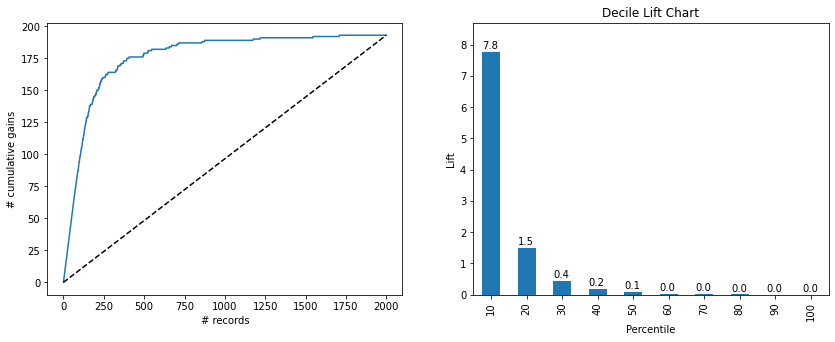

In [20]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
gainsChart(df.actual,ax=axes[0])
liftChart(df['p_1'],ax=axes[1])

## Flight Delays

In [21]:
delays = pd.read_csv('FlightDelays.csv')
delays.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [22]:
delays.DAY_WEEK=delays.DAY_WEEK.astype('category')
delays.CRS_DEP_TIME= [round(t/100) for t in delays.CRS_DEP_TIME]
delays.CRS_DEP_TIME=delays.CRS_DEP_TIME.astype('category')

In [23]:
delays['isdelayed'] = [1 if a == 'delayed' else 0 for a in delays['Flight Status']]
delays.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,isdelayed
0,15,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime,0
1,16,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime,0
2,12,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime,0
3,17,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime,0
4,10,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime,0


In [24]:
predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER', 'Weather']
outcome = 'isdelayed'

X=pd.get_dummies(delays[predictors], drop_first=True)
y = delays[outcome]



Split
declare model
fit model
predictioins
probabilities
data frame of predictions
confusion matrix
gains chart

## Flight Delays Summary

## Nominal logistic regression